## Easy Experiment .ipynb File

# train

## import

In [1]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random

import itertools

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [2]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [4]:
### cofiguration
seed = 42
check_point_dir_name = 'age_regression_resnet'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 100
epochs = 25
print_interval = 100
lr = 1e-4
model_name = 'resnet34'
num_labels = 1
loss_function_name = 'MSELoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
comment = 'For age Regression by efficient_b4'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [5]:
train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
labels = train_df['age'] # input your label feature
stratify_col = train_df['class']

train_paths, valid_paths, train_labels, valid_labels = train_test_split(imgs_path, labels,
                                                                        train_size=0.7,
                                                                        shuffle=True,
                                                                        random_state=seed,
                                                                        stratify=stratify_col)

In [6]:
os.makedirs(save_dir,exist_ok=True)

In [7]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : 1e-4,
'model_name' : model_name,
'num_labels' : num_labels,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'comment' : comment
}

In [8]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [9]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy()
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [10]:
train_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.HorizontalFlip(p=0.5),
                              A.RandomBrightnessContrast(p=0.5),
                              A.GaussianBlur(p=0.5),
                              A.GridDistortion(p=0.5),
                              A.Rotate(limit=30, p=0.5),
                              A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                              std=(0.23318603,0.24300033,0.24567522)),
                              ToTensorV2()])

valid_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                              std=(0.23318603,0.24300033,0.24567522)),
                              ToTensorV2()])

## make dataset and dataloader

In [11]:
train_dset = CustomTrainDataset(train_paths, train_labels, 'age', train_transforms)
val_dset = CustomTrainDataset(valid_paths, valid_labels, 'age', valid_transforms)

In [12]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

## visualization transform

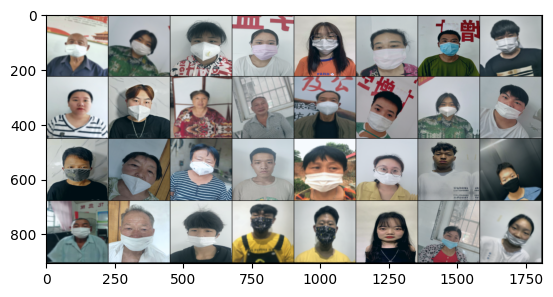

In [13]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [14]:
model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_labels)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [15]:
model = torch.nn.DataParallel(model)

In [16]:
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
# model(torch.Tensor(2,3,224,224).to(device)).size()

In [18]:
# b_labels.size()

## Loss function

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

In [20]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
elif loss_function_name == 'FocalLoss':
    criterion = FocalLoss()
elif loss_function_name == 'MSELoss':
    criterion = nn.MSELoss()
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

In [21]:
criterion

MSELoss()

## Optimizer

In [22]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr) 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

In [23]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.01
)

In [24]:
imgs, labels = next(iter(train_loader))
labels.unsqueeze(dim=1).size()
labels.size()

torch.Size([32])

## Train

In [25]:
best_val_loss = np.Inf
best_val_MAE = np.Inf

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, b_labels = train_batch # batch imgs and batch labels
        b_imgs = b_imgs.to(device)
        b_labels = b_labels.to(device)
        b_labels = b_labels.unsqueeze(dim=1)

        b_regressioned = model(b_imgs)

        # print(b_regressioned.size()) # 18
        # print(b_labels.size()) # 1

        b_loss = criterion(b_regressioned.to(torch.float32), b_labels.to(torch.float32)) ## 요거 정리

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        epoch_loss+=b_loss.item()
        iter_preds+=b_regressioned.detach().cpu().numpy().flatten().tolist() # for 1d dim
        iter_labels+=b_labels.detach().cpu().numpy().flatten().tolist() # for 1d dim

        epoch_preds+=iter_preds
        epoch_labels+=iter_labels

        iter_preds = []
        iter_labels = []

        # print interval batch
        if(idx+1) % print_interval == 0:
            current_loss = epoch_loss / (idx+1) # /batch
            correct_list = [abs(i-j) for i,j in zip(epoch_preds, epoch_labels)]
            current_MAE = sum(correct_list)/len(correct_list)
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss(MSE) {current_loss:2.4f} || training MAE {current_MAE:2.4f} || lr {lr}"
                )

    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()

        val_loss = []
        val_preds = [] # every data's preds
        val_labels = [] # every data's label

        for idx, val_batch in enumerate(val_loader):
            imgs, labels = val_batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(dim=1)
            b_preds = model(imgs)
            b_loss = criterion(b_preds, labels).item()
            val_loss.append(b_loss)

            val_preds += b_preds.detach().cpu().numpy().flatten().tolist()
            val_labels += labels.detach().cpu().numpy().flatten().tolist()

        epoch_val_MAE = mean_absolute_error(val_labels, val_preds)
        epoch_val_MSE =  mean_squared_error(val_labels, val_preds)
        best_val_MSE = min(best_val_loss, epoch_val_MSE)

        if epoch_val_MAE < best_val_MAE:
                print(f"New best model for val MAE : {epoch_val_MAE:2.4f}! saving the best model..")
                best_val_MAE = epoch_val_MAE
                torch.save(model.module.state_dict(), f"{save_dir}/best.pth")
        torch.save(model.module.state_dict(), f'{save_dir}/last.pth')
        print(
                f"[Val] MAE : {epoch_val_MAE:2.4f}, loss(MSE): {epoch_val_MSE:2.4f} || "
                f"best MAE : {best_val_MAE:2.4f}, best loss(MSE): {best_val_MSE:2.4f}"
            )


Epoch[1/25](100/414) || training loss(MSE) 885.3648 || training MAE 27.1702 || lr 0.0001
Epoch[1/25](200/414) || training loss(MSE) 603.1721 || training MAE 21.8554 || lr 0.0001
Epoch[1/25](300/414) || training loss(MSE) 454.4534 || training MAE 18.2645 || lr 0.0001
Epoch[1/25](400/414) || training loss(MSE) 357.3260 || training MAE 15.3494 || lr 0.0001
Calculating validation results...
New best model for val MAE : 5.7946! saving the best model..
[Val] MAE : 5.7946, loss(MSE): 44.8978 || best MAE : 5.7946, best loss(MSE): 44.8978
Epoch[2/25](100/414) || training loss(MSE) 35.5433 || training MAE 4.4543 || lr 0.0001
Epoch[2/25](200/414) || training loss(MSE) 32.8808 || training MAE 4.2106 || lr 0.0001
Epoch[2/25](300/414) || training loss(MSE) 30.9687 || training MAE 4.0440 || lr 0.0001
Epoch[2/25](400/414) || training loss(MSE) 29.6489 || training MAE 3.9513 || lr 0.0001
Calculating validation results...
New best model for val MAE : 4.3513! saving the best model..
[Val] MAE : 4.3513, l

```
efficientnet_b4
[Val] MAE : 1.0296, loss(MSE): 2.3298 || best MAE : 1.0296, best loss(MSE): 2.3298
```

```
resnet34
[Val] MAE : 1.3152, loss(MSE): 3.6210 || best MAE : 1.2977, best loss(MSE): 3.6210
```

In [26]:
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

# inference

## inference config

In [ ]:
model_name = 'resnet34'
check_point_dir_name = 'resnet34'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 1000
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [ ]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=num_labels)
model.to(device)
model.load_state_dict(torch.load(save_file_path))
model = torch.nn.DataParallel(model)

## test dataset

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_transforms = A.Compose([A.Resize(height=224, width=224),
                                 A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                                 std=(0.23318603,0.24300033,0.24567522)),
                                 ToTensorV2()])

In [ ]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [ ]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [ ]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [ ]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")